In [2]:
import pickle
import pandas as pd
import os
df = pd.read_pickle('data/trainingData.pkl')


In [3]:
df

,luftrtng,p_poli,p_apo,v_breitb50,v_breitb1000,p_nelade,p_selade,p_harzt,bev_dicht,bev_entw,...,Green_Areas,Water_Bodies,Landuse,Building_Types,All_Buildings,Buildings_With_Height_Levels,Health,Finance,All_Highways,Cycleways
0,9.59,3.20,2.69,99.520715,96.960895,2.841364,5.456455,2.215,1631.41,0.91,...,4,0,17,2051,8068,8070,72,45,2117,1
1,7.81,3.09,2.52,98.489685,93.469684,3.211509,4.912096,2.060,2087.80,-0.02,...,37,7,387,2553,4635,4670,199,77,7615,82
2,5.55,4.22,3.34,97.180070,88.940276,3.921645,6.579440,2.470,1018.23,0.16,...,88,66,160,3709,7159,7194,202,93,8225,694
3,8.01,3.08,2.81,98.309014,95.729833,4.538864,5.322970,2.835,1109.43,0.04,...,8,0,64,357,538,539,36,24,1628,7
4,13.78,6.98,5.67,98.693970,97.258949,4.731183,6.356069,3.885,193.27,-0.16,...,0,0,17,152,221,221,13,6,787,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10949,4.57,8.17,2.85,82.092098,0.625355,9.362754,3.797101,2.370,243.99,0.18,...,0,0,1,5,10,10,2,2,74,1
10950,3.78,6.77,7.41,84.722222,0.000000,7.145333,5.996667,7.250,27.78,-2.93,...,0,0,0,0,0,0,0,0,13,0
10951,3.89,6.50,6.28,30.134933,3.748126,7.882192,7.086575,2.780,88.14,-0.07,...,0,1,7,1,17,17,1,0,136,0
10955,6.89,14.71,9.40,80.686695,0.000000,13.170400,16.332000,1.790,63.97,-2.21,...,0,1,0,0,7,7,0,1,10,0


In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Remove 'preis_miet_best' from standardization, keep it in original scale
target_col = 'preis_miet_best'

# Standardize all columns except the target
features = df.drop(columns=[target_col])
scaler_features = StandardScaler()
features_standardized = pd.DataFrame(
    scaler_features.fit_transform(features),
    columns=features.columns,
    index=features.index
)

# Add the original target column back
df_standardized = features_standardized.copy()
df_standardized[target_col] = df[target_col]

df_standardized.head()


# Prepare features and target
X = df_standardized.drop('preis_miet_best', axis=1)
y = df_standardized['preis_miet_best']

# Remove rows with NaNs or Infs in X or y
valid_rows = X.notnull().all(axis=1) & np.isfinite(y)
X = X[valid_rows]
y = y[valid_rows]
y = y.clip(upper=df[target_col].quantile(0.99))


# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




In [5]:
constant_columns = [col for col in X_train.columns if X_train[col].nunique() <= 1]
print("Constant columns:", constant_columns)
X_train = X_train.drop(columns=constant_columns)
X_test = X_test.drop(columns=constant_columns)



Constant columns: ['Gastronomy']


# Random Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

param_dist_big = {
    'hidden_layer_sizes': [
        (50,), (100,), (150,), (50, 50), (80, 80), (100, 50), (60, 40),
        (120, 60), (80, 40), (100, 100), (150, 100), (50, 50, 50), (100, 50, 25)
    ],
    'alpha': uniform(1e-5, 5e-3),  # 0.00001 to 0.005
    'learning_rate_init': uniform(0.0001, 0.01),  # 0.0001 to 0.0101
}

mlp = MLPRegressor(
    activation='relu',
    solver='adam',
    learning_rate='constant',
    max_iter=300,
    early_stopping=True,
    random_state=42
)

random_search_big = RandomizedSearchCV(
    mlp,
    param_distributions=param_dist_big,
    n_iter=1500,
    cv=5,
    random_state=42,
    n_jobs=-1,  
    verbose=0,
)

random_search_big.fit(X_train, y_train)

print("Best parameters (big):", random_search_big.best_params_)
print("Best CV score (big):", random_search_big.best_score_)

best_model_big = random_search_big.best_estimator_
y_pred_big = best_model_big.predict(X_test)
rmse_big = np.sqrt(mean_squared_error(y_test, y_pred_big))
print("Test RMSE (big):", rmse_big)

# Refined Grid Search

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming X_train, y_train, X_test, y_test are already defined from your previous code
# For demonstration purposes, let's create some dummy data if you don't have it loaded
# from sklearn.datasets import make_regression
# from sklearn.model_selection import train_test_split
# X, y = make_regression(n_samples=1000, n_features=10, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Define the parameter grid for GridSearchCV
# Focus on values around the best parameters from RandomizedSearchCV

param_grid_grid_search = {
    'hidden_layer_sizes': [
        (50, 30), (60, 40), (70, 50),  # Centered around (60, 40)
        (60,), (40,) # Also consider slightly different architectures if they were close in random search
    ],
    'alpha': [
        0.0035, 0.0038, 0.0039, 0.0040, 0.0043  # Finer steps around 0.0039
    ],
    'learning_rate_init': [
        0.0095, 0.0098, 0.0099, 0.0100, 0.0102  # Finer steps around 0.0099
    ],
}

mlp_grid = MLPRegressor(
    activation='relu',
    solver='adam',
    learning_rate='constant',
    max_iter=300,
    early_stopping=True,
    random_state=42
)

grid_search = GridSearchCV(
    mlp_grid,
    param_grid=param_grid_grid_search,
    cv=5,
    n_jobs=-1,  # Use all available cores
    verbose=2,  # Set verbose to 2 to see more details during the search
)

# Fit the grid search to your training data
print("Starting Grid Search...")
grid_search.fit(X_train, y_train)
print("Grid Search Complete.")

# Print the best parameters and best score found by the grid search
print("\nBest parameters (Grid Search):", grid_search.best_params_)
print("Best CV score (Grid Search):", grid_search.best_score_)

# Evaluate the best model from grid search on the test set
best_model_grid = grid_search.best_estimator_
y_pred_grid = best_model_grid.predict(X_test)
rmse_grid = np.sqrt(mean_squared_error(y_test, y_pred_grid))
print("Test RMSE (Grid Search):", rmse_grid)

Starting Grid Search...
Fitting 5 folds for each of 125 candidates, totalling 625 fits
[CV] END alpha=0.0035, hidden_layer_sizes=(50, 30), learning_rate_init=0.0095; total time=   1.5s
[CV] END alpha=0.0035, hidden_layer_sizes=(50, 30), learning_rate_init=0.0095; total time=   2.0s
[CV] END alpha=0.0035, hidden_layer_sizes=(50, 30), learning_rate_init=0.0095; total time=   2.2s
[CV] END alpha=0.0035, hidden_layer_sizes=(50, 30), learning_rate_init=0.0098; total time=   1.6s
[CV] END alpha=0.0035, hidden_layer_sizes=(50, 30), learning_rate_init=0.0095; total time=   2.5s
[CV] END alpha=0.0035, hidden_layer_sizes=(50, 30), learning_rate_init=0.0098; total time=   2.7s
[CV] END alpha=0.0035, hidden_layer_sizes=(50, 30), learning_rate_init=0.0095; total time=   3.7s
[CV] END alpha=0.0035, hidden_layer_sizes=(50, 30), learning_rate_init=0.0098; total time=   3.8s
[CV] END alpha=0.0035, hidden_layer_sizes=(50, 30), learning_rate_init=0.0098; total time=   2.3s
[CV] END alpha=0.0035, hidden_l

In [10]:
import joblib
import os # For path manipulation

# Assuming you've successfully run the Bayesian Optimization code and
# 'best_model_bayes' is available from the previous execution.
# If not, you'll need to re-run the optimization first to get best_model_bayes.

# 1. Define the filename for your saved model
# It's good practice to include some identifying information, like the optimization method
model_filename = 'mlp_best_bayes_model.joblib'
# You can specify a directory if you want to save it elsewhere:
# model_directory = 'saved_models'
# os.makedirs(model_directory, exist_ok=True) # Create directory if it doesn't exist
# model_filepath = os.path.join(model_directory, model_filename)

# 2. Save the model
print(f"Saving the best model to {model_filename}...")
try:
    joblib.dump(best_model_grid, model_filename)
    print("Model saved successfully!")
except Exception as e:
    print(f"Error saving model: {e}")

# --- Optional: Verify by loading the model back ---
print(f"\nLoading the model from {model_filename} for verification...")
try:
    loaded_model = joblib.load(model_filename)
    print("Model loaded successfully!")

    # You can now use 'loaded_model' just like 'best_model_bayes'
    # For example, make predictions on the test set:
    y_pred_loaded = loaded_model.predict(X_test)
    rmse_loaded = np.sqrt(mean_squared_error(y_test, y_pred_loaded))
    print(f"Test RMSE with loaded model: {rmse_loaded}")

    # You can also check if the parameters are the same
    print(f"Loaded model's hidden_layer_sizes: {loaded_model.hidden_layer_sizes}")
    print(f"Original best model's hidden_layer_sizes: {best_model_bayes.hidden_layer_sizes}")

    if np.isclose(rmse_loaded, rmse_bayes):
        print("RMSE of loaded model matches the original best model (as expected).")
    else:
        print("WARNING: RMSE of loaded model does NOT match the original. There might be an issue.")

except FileNotFoundError:
    print(f"Error: Model file '{model_filename}' not found.")
except Exception as e:
    print(f"Error loading model: {e}")

Saving the best model to mlp_best_bayes_model.joblib...
Model saved successfully!

Loading the model from mlp_best_bayes_model.joblib for verification...
Model loaded successfully!
Error loading model: X has 20 features, but MLPRegressor is expecting 100 features as input.


/Users/leostrietzel/Documents/Projekte/Codes/VIZ&XAI/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


In [6]:
print("Best parameters (big):", random_search_big.best_params_)
print("Best CV score (big):", random_search_big.best_score_)

best_model_big = random_search_big.best_estimator_
y_pred_big = best_model_big.predict(X_test)
rmse_big = np.sqrt(mean_squared_error(y_test, y_pred_big))
print("Test RMSE (big):", rmse_big)


Best parameters (big): {'alpha': 0.003900126215723266, 'hidden_layer_sizes': (60, 40), 'learning_rate_init': 0.009933056568184674}
Best CV score (big): 0.8159648242453784
Test RMSE (big): 0.5227194743629947


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


### Best Parameter
Best parameters (big): {'alpha': 0.003900126215723266,
'hidden_layer_sizes': (60, 40), 
'learning_rate_init': 0.009933056568184674}
Best CV score (big): 0.8159648242453784
Test RMSE (big): 0.5227194743629947

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


  0%|          | 0/1977 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: in

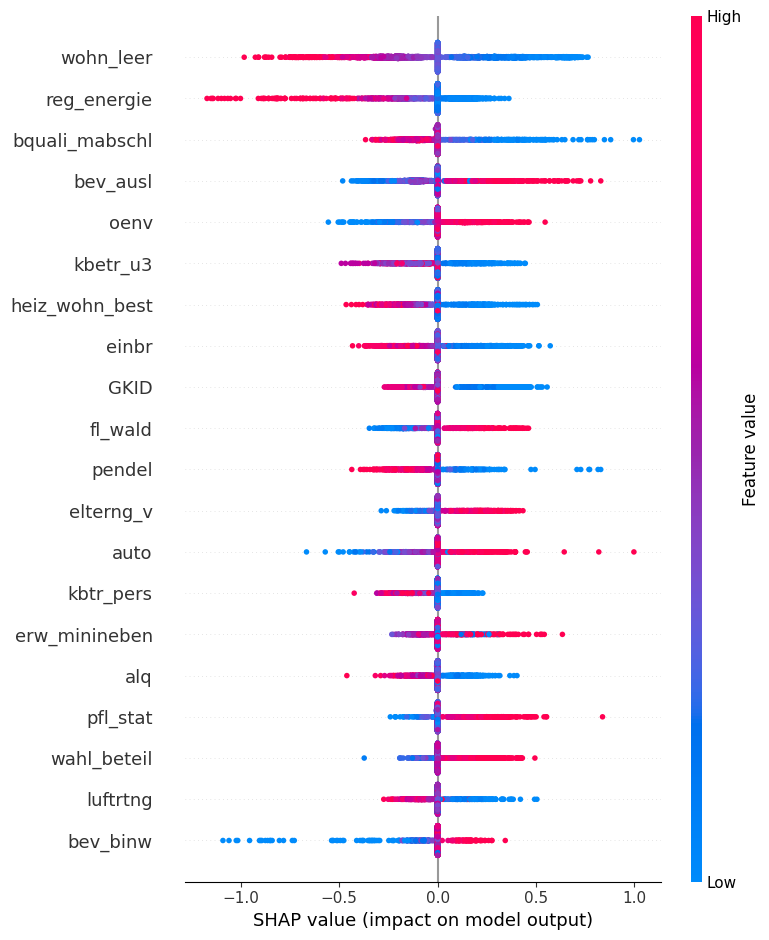

In [9]:
import shap

# Select a subset of the training data for SHAP to speed up computation
X_sample = X_train.sample(100, random_state=42)

# Create SHAP KernelExplainer for the MLPRegressor
explainer = shap.KernelExplainer(best_model_big.predict, X_sample)

# Calculate SHAP values for the test set (may take some time)
shap_values = explainer.shap_values(X_test)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test)